In [ ]:
!python -m spacy download en_core_web_md
!pip install spacytextblob

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

import re
import random

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1 užduotis.** Remdamiesi pasirinktu rinkiniu nustatykite sentimentų analizės tikslumą (angl. accuracy), gaunamą taikant VADER ir TextBlob leksikonus. Taip pat apskaičiuokite VADER ir TextBlob modelių preciziškumą (angl. precision), atkūrimą (angl. recall) ir F1-metriką.

In [5]:
# Define a function to read plain text files
def read_file(file_path):
  with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
    lines = file.readlines()
  # Remove any whitespace characters
  return [line.strip() for line in lines]

In [6]:
# Load the data
# neg_reviews = read_file('/content/drive/MyDrive/Colab Notebooks/Universitetas/VII Semestras/Natūralios kalbos apdorojimas/7 Paskaita/rt-polaritydata/rt-polaritydata/rt-polarity.neg')
# pos_reviews = read_file('/content/drive/MyDrive/Colab Notebooks/Universitetas/VII Semestras/Natūralios kalbos apdorojimas/7 Paskaita/rt-polaritydata/rt-polaritydata/rt-polarity.pos')

# If using colab file explorer
neg_reviews = read_file('/content/rt-polaritydata/rt-polarity.neg')
pos_reviews = read_file('/content/rt-polaritydata/rt-polarity.pos')

# The selected dataset is a collection of movie-review data for use in
# sentiment-polarity analysis experiments. More specifically, it is devided
# into two files, each containing positive and negative reviews, i.e.
#   * rt-polarity.neg contains 5331 negative reviews',
#   * rt-polarity.pos contains 5331 positive reviews'.
# The dataset can be found on 'https://www.cs.cornell.edu/people/pabo/movie-review-data/'

In [7]:
print('First 3 negative reviews:')
for i in range(3):
  print(f'{i+1}. {neg_reviews[i]}')

print()

print('First 3 positive reviews:')
for i in range(3):
  print(f'{i+1}. {pos_reviews[i]}')

First 3 negative reviews:
1. simplistic , silly and tedious .
2. it's so laddish and juvenile , only teenage boys could possibly find it funny .
3. exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable .

First 3 positive reviews:
1. the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
2. the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
3. effective but too-tepid biopic


In [8]:
# Add labels to the data: 0 for negative and 1 for positive reviews
neg_labels = ['neg'] * len(neg_reviews)
pos_labels = ['pos'] * len(pos_reviews)

# Combine the review data with the labels
all_labels = neg_labels + pos_labels
all_reviews = neg_reviews + pos_reviews

review_data = np.column_stack((all_labels, all_reviews))

# Create Pandas DataFrame from the review_data numpy array
dataset = pd.DataFrame(review_data, columns=['label', 'review'])
dataset.head()

,label,review
0,neg,"simplistic , silly and tedious ."
1,neg,"it's so laddish and juvenile , only teenage bo..."
2,neg,exploitative and largely devoid of the depth o...
3,neg,[garbus] discards the potential for pathologic...
4,neg,a visually flashy but narratively opaque and e...


In [9]:
# Import VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [10]:
# Define VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Add a predicted compound score column to the dataframe
dataset['score'] = dataset['review'].apply(lambda review: sia.polarity_scores(review)['compound'])
# Add a polarity label to each review based on compound scores
# Use only pos/neg labels, ignore neu label as the data given uses two labels
dataset['polarity'] = dataset['score'].apply(lambda score: 'pos' if score >= 0.0 else 'neg')
# dataset['polarity'] = dataset['scores'].apply(lambda score: 'pos' if score >= 0.05 else ('neg' if score <= -0.05 else 'neu'))

dataset.head()

,label,review,score,polarity
0,neg,"simplistic , silly and tedious .",0.0258,pos
1,neg,"it's so laddish and juvenile , only teenage bo...",0.4404,pos
2,neg,exploitative and largely devoid of the depth o...,0.0000,pos
3,neg,[garbus] discards the potential for pathologic...,-0.2500,neg
4,neg,a visually flashy but narratively opaque and e...,0.0000,pos


In [11]:
# Evaluate the predictions manually

true_positives = np.sum((dataset['label'] == 'pos') & (dataset['polarity'] == 'pos'))
true_negatives = np.sum((dataset['label'] == 'neg') & (dataset['polarity'] == 'neg'))
false_positives = np.sum((dataset['label'] == 'neg') & (dataset['polarity'] == 'pos'))
false_negatives = np.sum((dataset['label'] == 'pos') & (dataset['polarity'] == 'neg'))

accuracy = (true_positives + true_negatives) / (true_positives + true_negatives +\
                                                false_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * precision * recall / (precision + recall)

print(' - Evaluation of the predictions - ')
print(f'Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1: {f1:.4f}')

 - Evaluation of the predictions - 
Accuracy: 0.6119
Precision: 0.5787
Recall: 0.8224
F1: 0.6794


In [12]:
# Evaluate the predictions using scikit library

y_true = dataset['label'].values
y_pred = dataset['polarity'].values

acc = accuracy_score(y_true, y_pred)
pre = precision_score(y_true, y_pred, pos_label='pos')
rec = recall_score(y_true, y_pred, pos_label='pos')
f1s = f1_score(y_true, y_pred, pos_label='pos')

print(' - Evaluation using sklearn - ')
print(f'Accuracy: {acc:.4f}\nPrecision: {pre:.4f}\nRecall: {rec:.4f}\nF1: {f1s:.4f}')

 - Evaluation using sklearn - 
Accuracy: 0.6119
Precision: 0.5787
Recall: 0.8224
F1: 0.6794


In [13]:
# Load the language model
nlp = spacy.load('en_core_web_md')
# Enable sentiment analysis using TextBlob
nlp.add_pipe('spacytextblob')

In [14]:
# Reinitialize Pandas DataFrame only with reviews and their labels
dataset = pd.DataFrame(review_data, columns=['label', 'review'])

# Add a predicted polarity score column to the dataframe
dataset['score'] = dataset['review'].apply(lambda review: nlp(review)._.blob.polarity)
# Add polarity label to each review based on compound scores
# Use only pos/neg labels, ignore neu label as the data given uses two labels
dataset['polarity'] = dataset['score'].apply(lambda score: 'pos' if score >= 0.0 else 'neg')
# dataset['polarity'] = dataset['scores'].apply(lambda score: 'pos' if score >= 0.05 else ('neg' if score <= -0.05 else 'neu'))


In [15]:
dataset.head()

,label,review,score,polarity
0,neg,"simplistic , silly and tedious .",-0.50,neg
1,neg,"it's so laddish and juvenile , only teenage bo...",0.00,pos
2,neg,exploitative and largely devoid of the depth o...,-0.10,neg
3,neg,[garbus] discards the potential for pathologic...,-0.15,neg
4,neg,a visually flashy but narratively opaque and e...,-0.40,neg


In [16]:
# Evaluate the predictions using scikit library
y_true = dataset['label'].values
y_pred = dataset['polarity'].values

acc = accuracy_score(y_true, y_pred)
pre = precision_score(y_true, y_pred, pos_label='pos')
rec = recall_score(y_true, y_pred, pos_label='pos')
f1s = f1_score(y_true, y_pred, pos_label='pos')

print(' - Evaluation using sklearn - ')
print(f'Accuracy: {acc:.4f}\nPrecision: {pre:.4f}\nRecall: {rec:.4f}\nF1: {f1s:.4f}')

 - Evaluation using sklearn - 
Accuracy: 0.6215
Precision: 0.5830
Recall: 0.8527
F1: 0.6926


**2 užduotis.** Sukurkite mašininio mokymosi sentimentų klasifikavimo modelį, kuris leistų automatiškai nustatyti teigiamas ir neigiamas nuotaikas tekste.
1. padalinkite duomenų rinkinį į mokymosi ir testavimo rinkinius
2. išskirkite skaitinius požymius (požymius parinkite savo nuožiūra)
3. Apmokinkite pasirinktą modelį (galite rinktis vieną iš paskaitos metu aptartų
algoritmų).
4. Įvertinkite modelio tikslumą (angl. accuracy)

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
# Reinitialize Pandas DataFrame only with reviews and their labels
dataset = pd.DataFrame(review_data, columns=['label', 'review'])

# Add 3 numerical attributes to the data
# 1) Review length
# 2) Word count - the number of positive and negative words in a review
# 3) Punctuation - may indicate the intensity of sentiment in the review

In [19]:
# 1) Review length

def remove_punct(review):
  # Remove punctuation from the text
  review = re.sub('\W+', ' ', review)
  return review

def get_length(review):
  review = remove_punct(review)
  # Count number of words
  length = len(nltk.word_tokenize(review))
  return length

dataset['length'] = dataset['review'].apply(lambda review: get_length(review))

dataset.head()

,label,review,length
0,neg,"simplistic , silly and tedious .",4
1,neg,"it's so laddish and juvenile , only teenage bo...",14
2,neg,exploitative and largely devoid of the depth o...,21
3,neg,[garbus] discards the potential for pathologic...,16
4,neg,a visually flashy but narratively opaque and e...,14


In [132]:
# 2) Word count

def get_pos_neg_count(review, threshold=0.1):
  vader_lexicon = sia.lexicon
  positive_count = 0
  negative_count = 0
  review = remove_punct(review)
  for word in nltk.word_tokenize(review):
    if word in vader_lexicon:
      if vader_lexicon.get(word) > threshold:
        positive_count += 1
      elif vader_lexicon.get(word) < -threshold:
        negative_count += 1

  return positive_count, negative_count

dataset['pos_count'] = dataset['review'].apply(lambda review: get_pos_neg_count(review)[0])
dataset['neg_count'] = dataset['review'].apply(lambda review: get_pos_neg_count(review)[1])

dataset.head()

,label,review,length,pos_count,neg_count,punct
0,neg,"simplistic , silly and tedious .",4,0,0,2
1,neg,"it's so laddish and juvenile , only teenage bo...",14,1,0,2
2,neg,exploitative and largely devoid of the depth o...,21,0,0,1
3,neg,[garbus] discards the potential for pathologic...,16,0,1,3
4,neg,a visually flashy but narratively opaque and e...,14,0,0,1


In [21]:
# 3) Punctuation

def get_punct(review):
  punct = re.sub(r'[^.,!?;:-]', '', review)
  return punct

dataset['punct'] = dataset['review'].apply(lambda review: len(get_punct(review)))

dataset.head()

,label,review,length,pos_count,neg_count,punct
0,neg,"simplistic , silly and tedious .",4,0,0,2
1,neg,"it's so laddish and juvenile , only teenage bo...",14,1,0,2
2,neg,exploitative and largely devoid of the depth o...,21,0,0,1
3,neg,[garbus] discards the potential for pathologic...,16,0,1,3
4,neg,a visually flashy but narratively opaque and e...,14,0,0,1


In [22]:
def plot_histogram(feature):

  pos = dataset.loc[dataset['label'] == 'pos', feature]
  neg = dataset.loc[dataset['label'] == 'neg', feature]

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  axs[0].hist(pos, bins=50)
  axs[0].set_title(f'Positive review {feature} histogram')
  axs[0].set_xlabel(f'{feature} of a review')
  axs[0].set_ylabel('Frequency')

  axs[1].hist(neg, bins=50)
  axs[1].set_title(f'Negative review {feature} histogram')
  axs[1].set_xlabel(f'{feature} of a review')
  axs[1].set_ylabel('Frequency')

  plt.show()

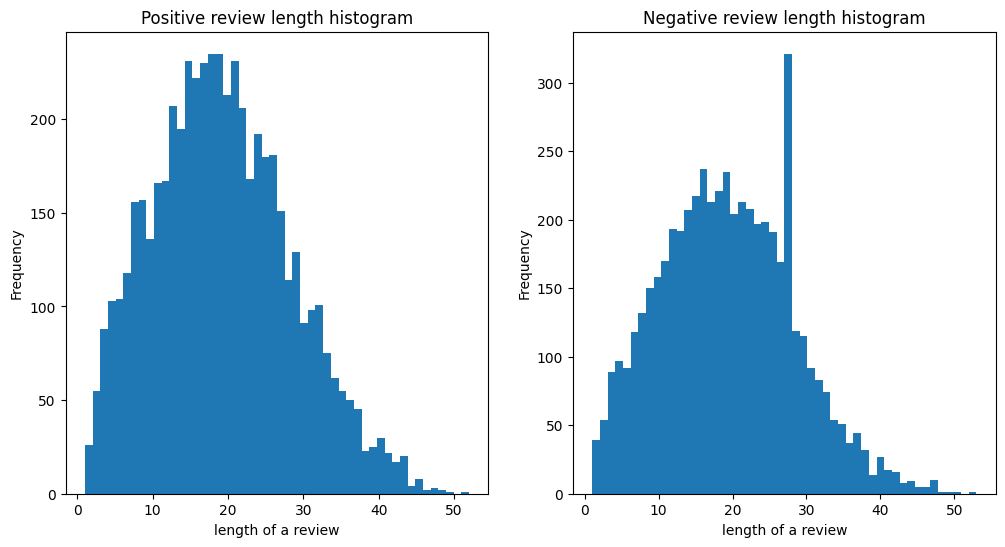

In [23]:
plot_histogram('length')

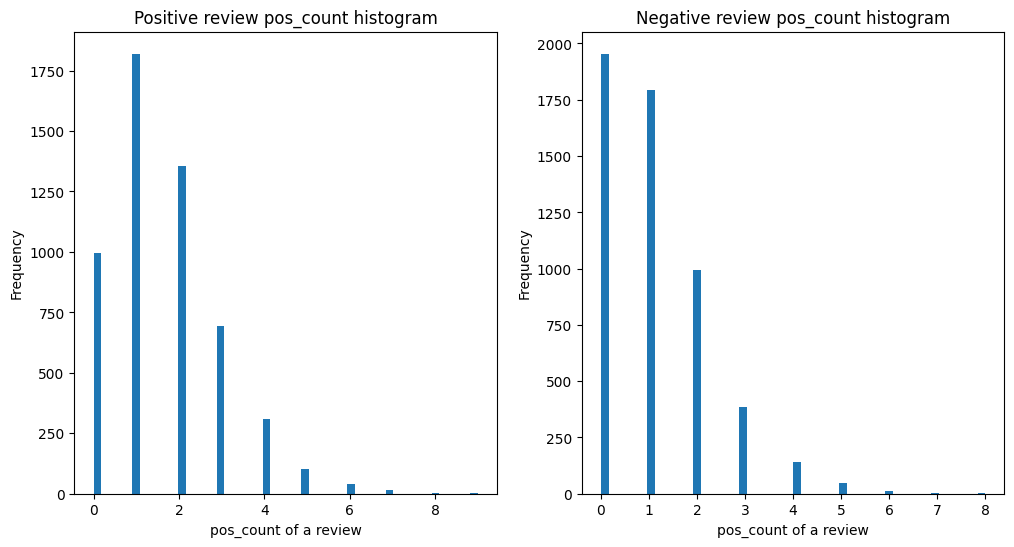

In [24]:
plot_histogram('pos_count')

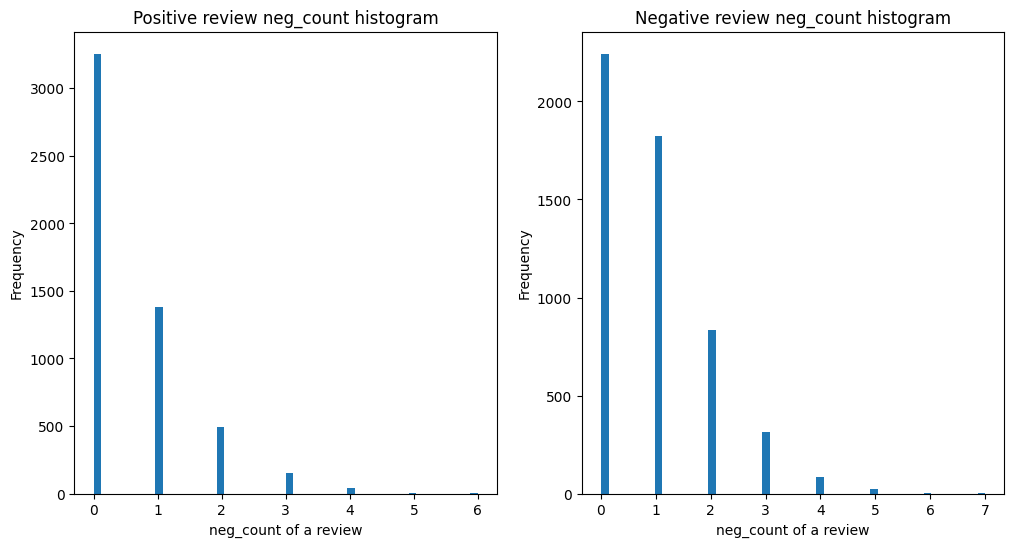

In [25]:
plot_histogram('neg_count')

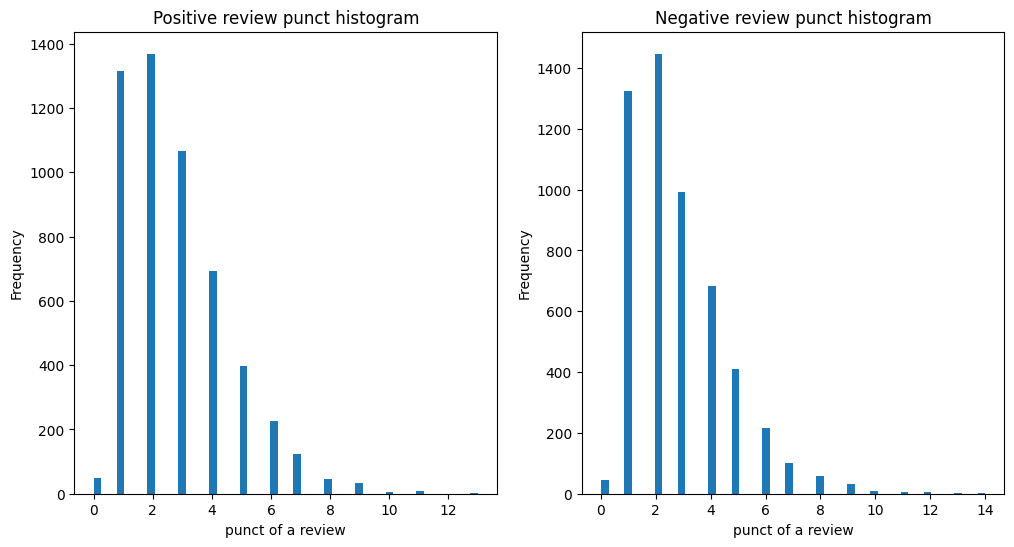

In [26]:
plot_histogram('punct')

In [31]:
# Convert data to numpy arrays
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values
# Encode labels to numerical value
y = np.where(y == 'pos', 1, 0)

# Split into training and testing sets
# Set shuffle to True, because input data is not distributed equally
# (first half of the reviews are neg and other half are pos)
# Add stratify to preserve the same distribution of labels
# (ratio of neg and pos reviews will be the same in train and test sets)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=42)

In [70]:
# Training the model only with numerical data
X_train_num = np.delete(X_train, 0, axis=1)
X_test_num = np.delete(X_test, 0, axis=1)

# Standardizing is preferred for SVM
sc = StandardScaler()
X_train_num = sc.fit_transform(X_train_num)
X_test_num = sc.transform(X_test_num)

# Fit the model with numerical values only
sv_classifier = SVC(gamma='scale')
sv_classifier.fit(X_train_num, y_train)

# Predict the outputs using test data
y_test_pred = sv_classifier.predict(X_test_num)

# Print results of predictions
report=classification_report(y_test, y_test_pred)
print(f'Model evaluation only using numerical features:\n{report}')

Model evaluation only using numerical features:
              precision    recall  f1-score   support

           0       0.62      0.65      0.64      1067
           1       0.63      0.61      0.62      1066

    accuracy                           0.63      2133
   macro avg       0.63      0.63      0.63      2133
weighted avg       0.63      0.63      0.63      2133



In [135]:
# Obtain a random index
random_index = random.randint(0, len(X_test_num) - 1)

# Get the features of a random sentence and its true label
random_sentence = X_test_num[random_index, :]
true_label = y_test[random_index]

# Standardize the features of a random sentence
# random_sentence_tfidf = vectorizer.transform([random_sentence])
random_sentence_sc = sc.transform([random_sentence])

# Make predictions on the random sentence
predicted_label = sv_classifier.predict(random_sentence_sc)

# Print the random sentence, its true label, and the predicted label
print(f'Random Sentence:\n{X_test[random_index, 0]}')
print(f'True Label: {("positive" if true_label == 1 else "negative")}')
print(f'Predicted Label: {("positive" if predicted_label[0] == 1 else "negative")}')

Random Sentence:
tries to add some spice to its quirky sentiments but the taste is all too familiar .
True Label: negative
Predicted Label: negative


In [ ]:
# Initialize a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Separate the reviews from the training data
X_train_text = X_train[:, 0]
X_test_text = X_test[:, 0]

X_train_num = np.delete(X_train, 0, axis=1)
X_test_num = np.delete(X_test, 0, axis=1)

preprocessor = make_column_transformer(
        (TfidfVectorizer(), 0),
        (StandardScaler(), slice(1, None)),
        remainder='passthrough')

svm_classifier = SVC()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', svm_classifier)
])

pipeline.fit(X_train, y_train)

In [89]:
# Define the hyperparameter grid to search
param_grid = {
    'svm__C': [0.1, 1, 10],  # Adjust the range of C values
    'svm__kernel': ['linear', 'rbf'],  # Adjust the kernel options
    'svm__gamma': ['scale', 'auto', 0.1, 1],  # Adjust the gamma values
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5)  # You can adjust the number of cross-validation folds (cv) as needed

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best parameters and best estimator
print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(), 0),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  slice(1, None, None))])),
                ('svm', SVC(C=1, kernel='linear'))])


In [121]:
y_test_pred = best_estimator.predict(X_test)
print(X_test.shape)
print(X_test[0, :].shape)
# Print results of predictions
report=classification_report(y_test, y_test_pred)
print(f'Model evaluation:\n{report}')

(2133, 5)
(5,)
Model evaluation:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1067
           1       0.78      0.77      0.77      1066

    accuracy                           0.77      2133
   macro avg       0.77      0.77      0.77      2133
weighted avg       0.77      0.77      0.77      2133



In [136]:
# Obtain a random index
random_index = random.randint(0, len(X_test_num) - 1)

# Get the random sentence and its true label
random_instance = X_test[random_index, :]
random_sentence = random_instance[0]

true_label = y_test[random_index]

# Transform each feature of the instance
# random_sentence_preprocessed = preprocessor.transform([random_instance])

# Make predictions on the random sentence
predicted_label = best_estimator.predict([random_instance])

# Print the random sentence, its true label, and the predicted label
print(f'Random Sentence:\n{random_sentence}')
print(f'True Label: {("positive" if true_label == 1 else "negative")}')
print(f'Predicted Label: {("positive" if predicted_label == 1 else "negative")}')

Random Sentence:
the plot is so predictable and sentimental that viewers are likely to lose interest before sandrine and her goats walk off into the sunset .
True Label: negative
Predicted Label: negative
